In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import albumentations as A
import open_clip
import torch
from PIL import Image
import numpy as np
import sys
sys.path.append("../tools")
from utils import plot_tensor, plot_pil_img, plot_np_array
from time import time

/home/lsaland/micromamba/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
	A.OneOf([
    A.ImageCompression(quality_lower=40,quality_upper=40,p=1/3),
    A.ImageCompression(quality_lower=65,quality_upper=65,p=1/3),
	A.ImageCompression(quality_lower=90,quality_upper=90,p=1/3),
    ], p=3/4)
    ], p=1.0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K',device=device)

In [5]:
type(preprocess)

torchvision.transforms.transforms.Compose

In [6]:
type(transform)

albumentations.core.composition.Compose

In [17]:
img = Image.open("/data3/AID_pairs_orig_gen/originals/002_pjpg_49316815836_o.jpg")

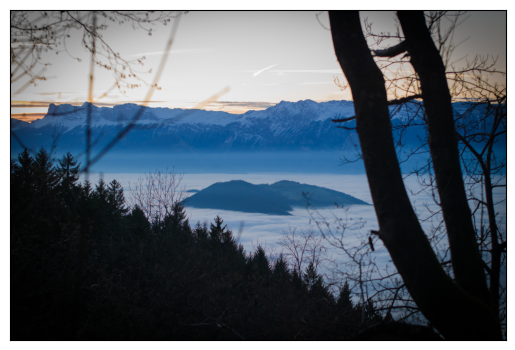

In [19]:
plot_pil_img(img)

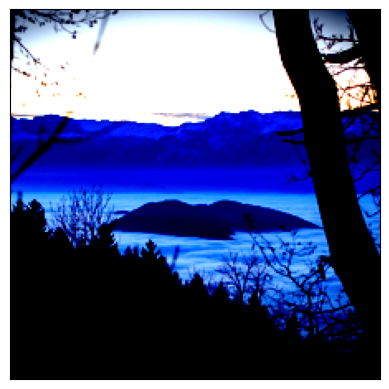

In [20]:
plot_tensor(preprocess(img))

In [17]:
%timeit preprocess(img)

79.6 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit transform(image=np.array(img.convert("RGB")))

170 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit preprocess(Image.fromarray(transform(image=np.array(img.convert("RGB")))["image"]))

269 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K',device=device)
model.eval()
model.cuda()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwi

In [31]:
pre = preprocess(img).unsqueeze(0).cuda()

In [32]:
%%timeit
with torch.no_grad():
    model.encode_image(pre)

16.3 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
tensor = torch.randint(0,100,(3,224,224)).float()

In [37]:
%timeit tensor.cuda()

92.5 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
l = [torch.randn(3,224,224).unsqueeze(0) for i in range(1000)]
%timeit torch.cat(l,dim=0)

The slowest run took 4.71 times longer than the fastest. This could mean that an intermediate result is being cached.
380 ms ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
features = torch.cat(l,dim=0)
%timeit features.cuda()

94 ms ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


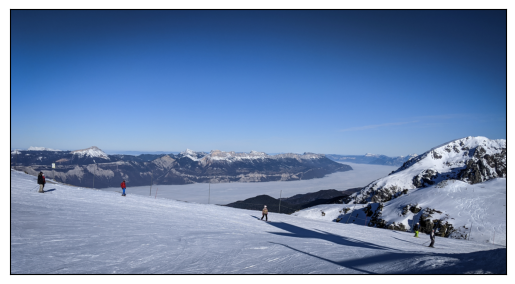

In [20]:
plot_pil_img(img)

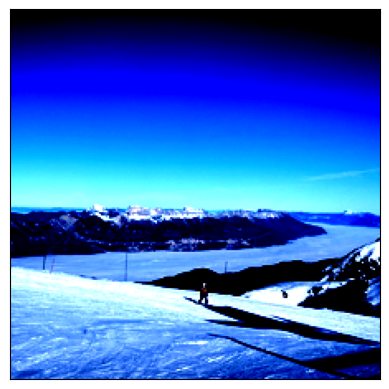

In [21]:
plot_tensor(preprocess(img))

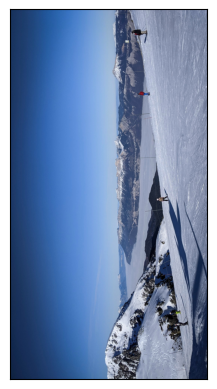

In [22]:
plot_np_array(transform(image=np.array(img.convert("RGB")))["image"])

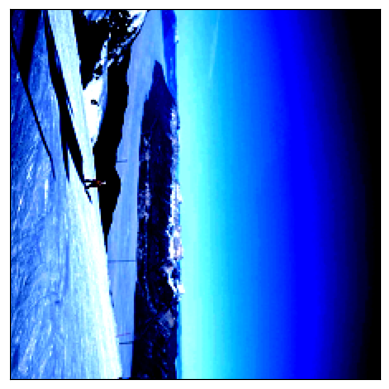

In [25]:
pre = preprocess(Image.fromarray(transform(image=np.array(img.convert("RGB")))["image"]))
plot_tensor(pre)

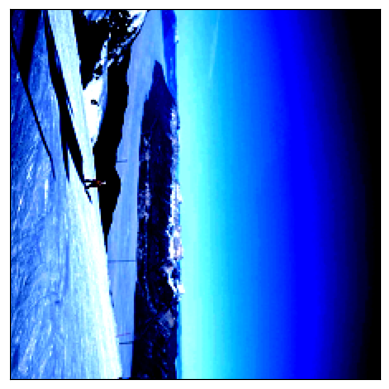

In [26]:
from torchvision.transforms import ToPILImage

plot_pil_img(pre.permute(1,2,0).numpy())